# Compare ODE solvers with PEtab in Julia

For most modeling tasks, like exploring model behavior by scanning the parameter space, estimating parameters, doing Bayesian inference the underlying dynamic Ordinary Differential Equation (ODE) model must be simulated with an ODE solver. A general guide for selecting solvers is available [here](https://sebapersson.github.io/PEtab.jl/stable/Best_options/), however the optimal solver choice is problem specific. Therefore, comparing solvers based on accuracy and runtime can provide valuable insights, and this notebook shows how to do these comparisons for PEtab problems.

## Setup

The packages needed are:

- **PEtab.jl**: For importing PEtab problems.
- **OrdinaryDiffEq.jl**: For simulating ODE models.
- **Plots.jl** and **StatsPlots.jl**: For visualizing simulation results.

In [1]:
using OrdinaryDiffEq, PEtab, Plots, StatsPlots

## Computing Accuracy and Runtime for an ODE solver

As a case study we use a Jak-Stat signaling model with its PEtab problem files located in the *Assets/Boehm_JProteomeRes2014/* directory. First the PEtab problem is imported into Julia (see [here](https://github.com/sebapersson/SysBioNotebooks/blob/main/Simulate_model/PEtab_ODE.ipynb) for import tutorial).

In [3]:
path_petab_problem = joinpath(@__DIR__, "Assets", "Boehm_JProteomeRes2014", "Boehm_JProteomeRes2014.yaml")
petab_model = PEtabModel(path_petab_problem; verbose=false)
petab_problem = PEtabODEProblem(petab_model; verbose=false)
xpetab = petab_problem.θ_nominalT
xpetab_names = petab_problem.θ_names
# Print parameters
[(xpetab_names[i] => xpetab[i]) for i in eachindex(xpetab)]

9-element Vector{Pair{Symbol, Float64}}:
 :Epo_degradation_BaF3 => -1.5689175883999988
         :k_exp_hetero => -4.999704893599998
           :k_exp_homo => -2.2096987817000167
         :k_imp_hetero => -1.78600654750001
           :k_imp_homo => 4.9901140088
               :k_phos => 4.1977354885
       :sd_pSTAT5A_rel => 0.5857552705999998
       :sd_pSTAT5B_rel => 0.8189828191999999
       :sd_rSTAT5A_rel => 0.49868440400000047

Here `xpetab` represents the parameter values defined in the PEtab file, and they are on a log10 scale. To evaluate both the runtime and accuracy when simulating the model for all simulation conditions with the `Rodas5P()` ODE solver with tolerances set to `abstol=reltol=1e-8` (default) do:

In [4]:
using Printf
include(joinpath(@__DIR__, "..", "src", "Util.jl"))
runtime, acc = compute_runtime_accuracy(xpetab, petab_problem, Rodas5P(); abstol=1e-8, reltol=1e-8)
@printf("Runtime Rodas5P = %.2e seconds with squared error = %.2e\n", runtime, acc)

Runtime Rodas5P = 7.52e-04 seconds with squared error = 8.98e-14


Accuracy is determined by calculating the squared differences compared to a high accuracy solution (low solver tolerances). To customize high accuracy solver options, refer to the `compute_runtime_accuracy` function's documentation (can be accessed by in the Julia REPL by entering `?compute_runtime_accuracy`). 

Given this we can compare the stiff `Rodas5P()` solver (suitable for stiff problems), and a non-stiff solver such as `Vern7()`.

In [5]:
using Printf
include(joinpath(@__DIR__, "..", "src", "Util.jl"))
runtime, acc = compute_runtime_accuracy(xpetab, petab_problem, Vern7(); abstol=1e-8, reltol=1e-8)
@printf("Runtime Vern7 = %.2e seconds with squared error = %.2e\n", runtime, acc)

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /home/sebpe/.julia/packages/SciMLBase/SiUHW/src/integrator_interface.jl:585
┌ Warning: Could not solve ODE. Runtime and accuracy are returned as Inf
└ @ Main /home/sebpe/Dropbox/PhD/Projects/SysBioNotebooks/src/Util.jl:41


Runtime Vern7 = Inf seconds with squared error = Inf


Here the `Vern7()` ODE solver was unable to solve the model due to it being stiff. Typically, explicit (non-stiff) solver are faster for non-stiff problems. To potentially use the advantages of both stiff and non-stiff solvers, we can use a composite solver that combines and switch between a stiff and non-stiff solver when suitable:

In [6]:
using Printf
include(joinpath(@__DIR__, "..", "src", "Util.jl"))
runtime, acc = compute_runtime_accuracy(xpetab, petab_problem, AutoVern7(Rodas5P()); abstol=1e-8, reltol=1e-8)
@printf("Runtime Vern7(Rodas5P()) = %.2e seconds with squared error = %.2e\n", runtime, acc)

Runtime Vern7(Rodas5P()) = 9.67e-04 seconds with squared error = 8.77e-14


### Evaluate Runtime and Accuracy for several parameter combinations

The above results from the Jak-Stat signaling model indicate that the stiff solver `Rodas5P()` performs comparably to the composite solver `AutoVern7(Rodas5P())`. However, drawing conclusions from a single dataset is not recommended, especially since in practical modeling scenarios where the model is not always simulated close to the parameter values specified in `xpetab` (often the reported values). For instance, during parameter estimation or while exploring the parameter space, the model is simulated for random parameter combinations.

To assess runtime and accuracy across a range of parameter values, we can generate a set of random parameter vectors within the constraints defined by the PEtab problem. For example, we could generate 100 random parameter combinations:

In [7]:
xrandom = generate_startguesses(petab_problem, 100)

9×100 Matrix{Float64}:
 -1.25   4.05  -1.55   0.95   0.75  …   3.85   2.25  -4.95  -2.25  -4.05
 -4.55  -1.95   4.75  -1.65   4.95      0.65  -4.05   3.65   4.55   0.15
 -3.45   4.85   0.95   2.95   4.15     -2.25   4.65   1.55  -0.75  -1.05
  3.95   0.35   1.25   3.65   0.15      0.25   1.85  -4.05   1.95   2.15
  4.95   1.25   1.45   0.45  -1.05     -4.35  -4.15  -2.25  -4.05   3.65
 -0.65  -1.05   3.95   0.85  -3.85  …  -2.15  -4.25  -0.45   2.25  -3.45
 -2.45   2.65   2.15  -0.95   1.35     -4.45   4.55   0.55  -3.05   1.05
 -0.65   4.65   4.35   3.35  -3.15      3.15   4.85   4.95   1.55  -4.55
  1.55   3.25  -4.75  -0.05  -1.85     -2.85  -1.15  -2.45  -4.15   4.25

Each column of `xrandom` represents a distinct parameter vector. With these random parameter combinations, we can do a more realistic comparison:

In [11]:
runtime_rodas5P, acc_rodas5P = zeros(100), zeros(100)
runtime_composite, acc_composite = zeros(100), zeros(100)
for i in 1:100
    x = xrandom[:, i]
    runtime_rodas5P[i], acc_rodas5P[i] = compute_runtime_accuracy(x, petab_problem, Rodas5P(); abstol=1e-8, reltol=1e-8)
    runtime_composite[i], acc_composite[i] = compute_runtime_accuracy(x, petab_problem, AutoVern7(Rodas5P()); abstol=1e-8, reltol=1e-8)
end

And we can plot both the accuracy and runtime

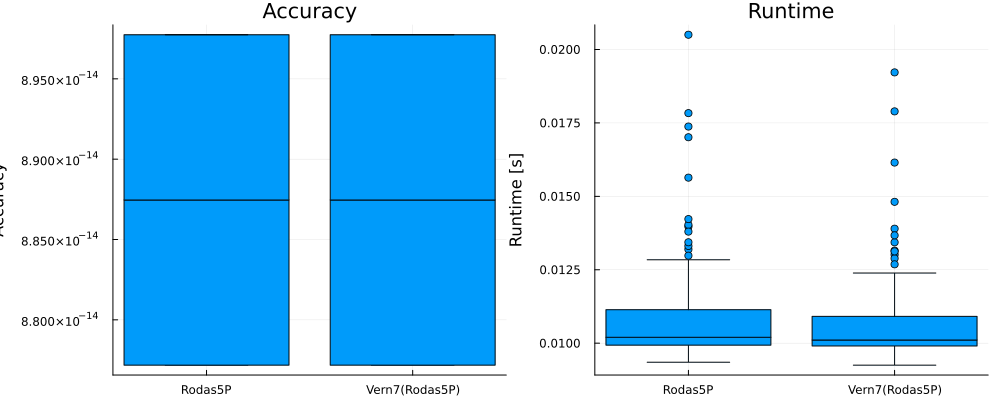

In [12]:
xaxis = repeat(["Rodas5P", "Vern7(Rodas5P)"], outer=100)
p1 = boxplot(xaxis, vcat(acc_rodas5P, acc_composite), ylabel="Accuracy", label=false, title = "Accuracy")
p2 = boxplot(xaxis, vcat(runtime_rodas5P, runtime_composite), ylabel="Runtime [s]", label=false, title = "Runtime")
plot(p1, p2, layout=(1, 2), size=(1000, 400))

Both solvers achieve nearly identical accuracy levels, yet the stiff solver `Rodas5P()` is faster. Generally, for stiff models—which are common in systems biology (e.g. signaling pathways), stiff solvers often outperform composite solvers. Conversely, for models such as SIR (Susceptible-Infected-Recovered), our benchmarks indicate that a composite solver might be the preferable option. It is rare for a non-stiff solver to be the optimal choice in these contexts.

## Testing ODE solvers for a larger model

The `Rodas5P()` solver belongs to the Rosenbrock family of solvers, which are efficient for smaller models. For larger models, BDF (Backward Differentiation Formula) solvers, such as `QNDF()` or `CVODE_BDF()`, often are more efficient. To see this, consider a case study with a larger model of Jak-Stat5 signaling:

In [13]:
path_petab_problem = joinpath(@__DIR__, "Assets", "Bachmann_MSB2011", "Bachmann_MSB2011.yaml")
petab_model = PEtabModel(path_petab_problem; verbose=false)
petab_problem = PEtabODEProblem(petab_model; verbose=false)
xpetab = petab_problem.θ_nominalT
xpetab_names = petab_problem.θ_names
# Print parameters
[(xpetab_names[i] => xpetab[i]) for i in eachindex(xpetab)]

113-element Vector{Pair{Symbol, Float64}}:
               :CISEqc => 2.6363414626000004
             :CISEqcOE => -0.2755010668
               :CISInh => 8.8949919309
          :CISRNADelay => -0.8393003979999987
           :CISRNATurn => 3.0
              :CISTurn => -2.0757814662000005
          :EpoRActJAK2 => -0.5730015944999994
           :EpoRCISInh => 6.0
        :EpoRCISRemove => 0.7347912578000002
           :JAK2ActEpo => 5.8015094987
                       ⋮
   :offset_SOCS3_cisoe => -0.5555331409999996
    :scale_SOCS3_cisoe => 1.0632663513999994
 :scale_SOCS3RNA_foldA => 1.7555939306000004
 :scale_SOCS3RNA_foldB => 1.6908602127999999
 :scale_SOCS3RNA_foldC => 1.9070440011000003
    :scale_SHP1_shp1oe => -0.646761916
    :scale_tSTAT5_long => -0.11796318619999974
  :scale_tSTAT5_shp1oe => -0.16678824309999976
    :scale_tSTAT5_actd => -0.08873199230000008

If we compare the `Rodas5P()` and `QNDF()` solvers:

In [15]:
using Printf
include(joinpath(@__DIR__, "..", "src", "Util.jl"))
runtime_rodas, acc_rodas = compute_runtime_accuracy(xpetab, petab_problem, Rodas5P(); abstol=1e-8, reltol=1e-8)
runtime_qndf, acc_qndf = compute_runtime_accuracy(xpetab, petab_problem, QNDF(); abstol=1e-8, reltol=1e-8)
@printf("Runtime Rodas5P = %.2e seconds with squared error = %.2e\n", runtime_rodas, acc_rodas)
@printf("Runtime QNDF = %.2e seconds with squared error = %.2e\n", runtime_qndf, acc_qndf)

Runtime Rodas5P = 6.08e-02 seconds with squared error = 4.31e-08
Runtime QNDF = 5.82e-02 seconds with squared error = 5.47e-04


`QNDF` is faster while `Rodas5P` maintains higher accuracy, which highlights the trade-off between computational speed and solution precision. To compare solvers with this in mind, a work-precision diagram can be employed. This involves solving the model at various solver tolerances:

In [18]:
tols = [1e-8, 1e-7, 1e-6, 1e-5]
runtime_rodas, acc_rodas = zeros(4), zeros(4)
runtime_qndf, acc_qndf = zeros(4), zeros(4)
for (i, tol) in pairs(tols)
    runtime_rodas[i], acc_rodas[i] = compute_runtime_accuracy(xpetab, petab_problem, Rodas5P(); abstol=tol, reltol=tol)
    runtime_qndf[i], acc_qndf[i] = compute_runtime_accuracy(xpetab, petab_problem, QNDF(); abstol=tol, reltol=tol)
end

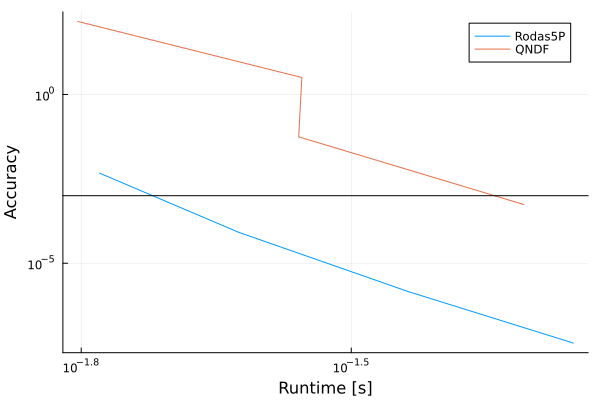

In [19]:
plot(runtime_rodas, acc_rodas, xlabel="Runtime [s]", ylabel="Accuracy", label="Rodas5P", xaxis=:log10, yaxis=:log10)
plot!(runtime_qndf, acc_qndf, xlabel="Runtime [s]", ylabel="Accuracy", label="QNDF")
hline!([1e-3], color="Black", label=false)

The work-precision diagram indicates that for a specified accuracy level (e.g., `1e-3`, as indicated by a horizontal line), `Rodas5P` is more efficient. However, several factors should be taken into account:

1. Although not as precise as `Rodas5P`, the accuracy of `QNDF` is still good.
2. The analysis is based on a single parameter vector.
3. The performance of solvers when calculating gradients can differ from their performance in solving the ODE itself.

If we consider the third point, and compare gradient runtime:

In [20]:
prob1 = PEtabODEProblem(petab_model; verbose=false, ode_solver_gradient=ODESolver(Rodas5P()))
prob2 = PEtabODEProblem(petab_model; verbose=false, ode_solver_gradient=ODESolver(QNDF()))
# For precompiling
_ = prob1.compute_gradient(xpetab)
_ = prob2.compute_gradient(xpetab)
runtime_Rodas5P = 0.0
runtime_QNDF = 0.0
# Measure 5 times and take the mean
for i in 1:5
    runtime_Rodas5P += @elapsed _ = prob1.compute_gradient(xpetab)
    runtime_QNDF += @elapsed _ = prob2.compute_gradient(xpetab)
end
@printf("Runtime Rodas5P = %.2e seconds and runtime QNDF = %.2e seconds\n", runtime_Rodas5P / 5, runtime_QNDF / 5)

Runtime Rodas5P = 4.08e+00 seconds and runtime QNDF = 1.92e+00 seconds


The noticeable increase in runtime difference, and larger difference in solver time for gradient computations highlights the importance of carefully selecting a solver based on the specific requirements of a modeling task. For activities like parameter space exploration that mainly involve solving the ODE, using a work-precision diagram with random parameter vectors can effectively guide solver selection. However, for tasks that require gradient computations, such as parameter estimation, it is important to consider that runtime differences are often larger for the gradient compared to just solving the ODE. In such cases, if a BDF solver like `QNDF` is faster at simulating the ODE, it might be advantageous to opt for a BDF solver. It is also important to note that the model discussed here is relatively small, with 25 species. As model size increases, the runtime differences between Rosenbrock solvers, like `Rodas5P`, and BDF solvers, like `QNDF`, often increase.

Regardless, for larger models it can be worthwhile to compare ODE solvers across random parameter vectors. For example, to compare `QNDF` versus `FBDF` do:

In [21]:
xrandom = generate_startguesses(petab_problem, 20)
runtime_fbdf, acc_fbdf = zeros(20), zeros(20)
runtime_qndf, acc_qndf = zeros(20), zeros(20)
for i in 1:20
    x = xrandom[:, i]
    runtime_fbdf[i], acc_fbdf[i] = compute_runtime_accuracy(x, petab_problem, FBDF(); abstol=1e-8, reltol=1e-8)
    runtime_qndf[i], acc_qndf[i] = compute_runtime_accuracy(x, petab_problem, QNDF(); abstol=1e-8, reltol=1e-8)
end

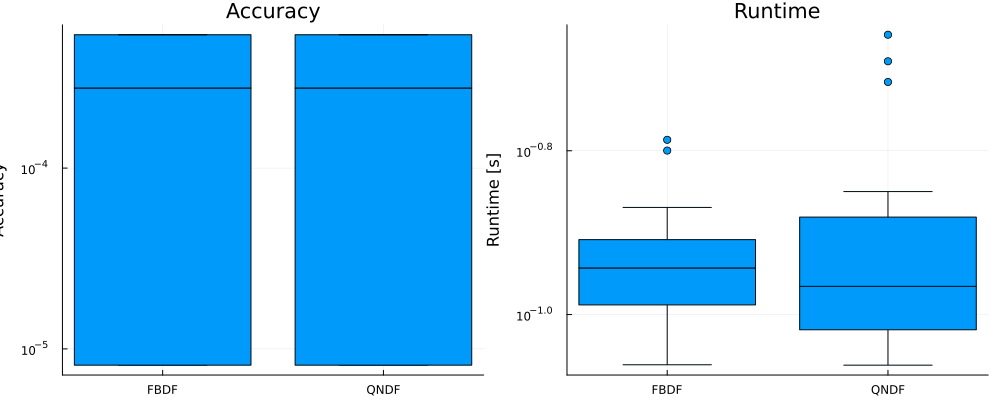

In [22]:
xaxis = repeat(["FBDF", "QNDF"], outer=20)
p1 = boxplot(xaxis, vcat(acc_fbdf, acc_qndf), ylabel="Accuracy", label=false, title = "Accuracy", yaxis=:log10)
p2 = boxplot(xaxis, vcat(runtime_fbdf, runtime_qndf), ylabel="Runtime [s]", label=false, title = "Runtime", yaxis=:log10)
plot(p1, p2, layout=(1, 2), size=(1000, 400))

The comparison reveals a slight advantage for the `QNDF` solver.

As a disclaimer, the best solver choice is highly dependent on the specific problem at hand. Generally, Rosenbrock solvers tend to perform well for smaller models. As model sizes increase, BDF solvers like `QNDF` often are more efficient, however, SDIRK solvers such as `KenCarp4` can also be efficient for larger models ADD! Therefore, it can be worthwhile to compare different solvers prior to modeling.
